[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Yurik\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
C:\Users\Yurik\AppData\Local\Temp\ipykernel_17996\4163095152.py:81: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  label_encoder.fit(y_test.append(y_train))


Top-3 Accuracy: 0.7308558558558559
Precision-at-3: 0.24361861861863948
Precision at threshold 0.3: 0.268018018018018


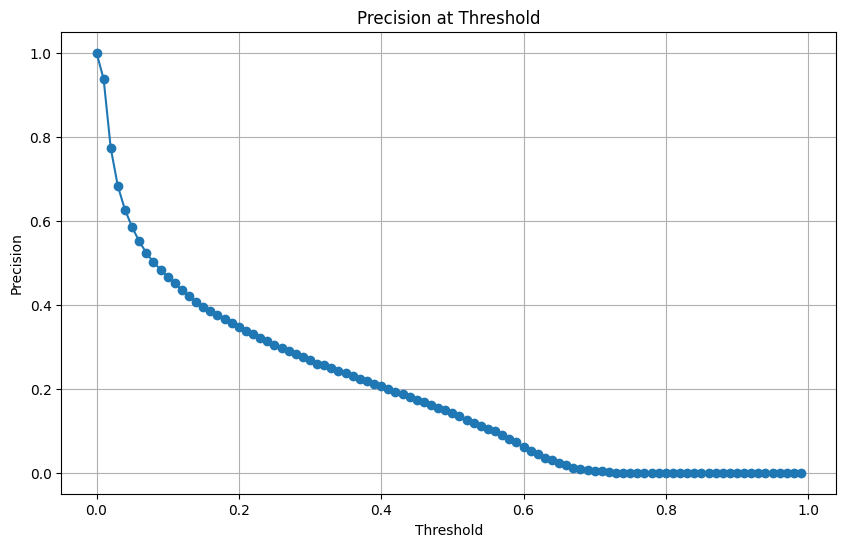

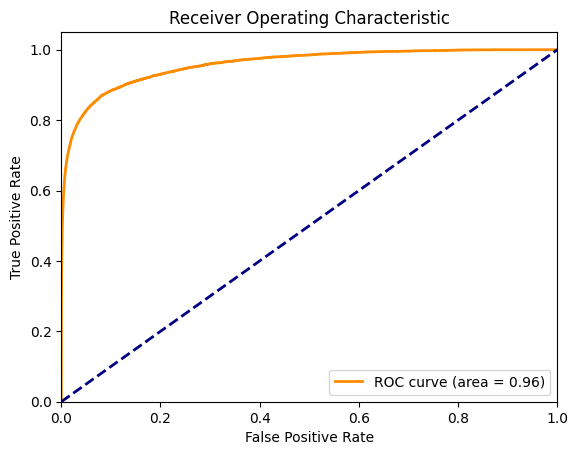

Custom Accuracy: 3291
              precision    recall  f1-score   support

           0       0.64      0.21      0.32       133
           1       0.00      0.00      0.00        84
           2       0.79      0.09      0.16       122
           3       0.88      0.11      0.20       122
           4       0.93      0.15      0.26        94
           5       0.94      0.63      0.76       106
           6       0.81      0.29      0.42       101
           7       0.94      0.28      0.43       112
           8       0.89      0.05      0.10       147
           9       0.87      0.19      0.31       214
          10       0.00      0.00      0.00        68
          11       0.43      0.14      0.21       105
          12       0.00      0.00      0.00        88
          13       0.98      0.33      0.49       190
          14       0.84      0.09      0.15       188
          15       0.88      0.31      0.46       117
          16       0.84      0.27      0.41       182
     

In [10]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import label_binarize
import re
import sqlite3
import nltk
from nltk.corpus import stopwords
import pickle
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
import numpy as np

nltk.download('stopwords')
russian_stopwords = stopwords.words('russian')

conn = sqlite3.connect('yt_videos_for_train_labeled.db')
videos_df = pd.read_sql('SELECT * FROM videos', conn)

# Предобработка текста
def clean_text(text):
    text = re.sub(r'<.*?>', '', text)
    text = re.sub(r'\d+', '', text)
    text = re.sub(r'[^\w\s]', '', text)
    text = text.lower()
    return text

videos_df['text'] = videos_df['video_title'].astype(str) + " " + videos_df['video_description'].astype(str)
videos_df['text'] = videos_df['text'].apply(clean_text)

X = videos_df['text']
y = videos_df['profession']

# Разделение данных на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Создание конвейера с TF-IDF векторизацией и логистической регрессией
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words=russian_stopwords)),
    ('clf', LogisticRegression(solver='liblinear'))
])

pipeline.fit(X_train, y_train)

# Функция для оценки наличия лейбла с учетом порогового значения
def custom_predict(probas, threshold=0.3):
    return (probas >= threshold).astype(int)

# Предсказание вероятностей для тестовых данных
probabilities = pipeline.predict_proba(X_test)

unique_classes = np.unique(y_test)

# Изменение y_test_actual для соответствия формату predictions
y_test_actual = label_binarize(y_test, classes=unique_classes)

# Функция для вычисления Top-k Accuracy
def top_k_accuracy(y_true, y_prob, k=3):
    # Получаем индексы топ-k предсказанных вероятностей
    top_k_preds = np.argsort(y_prob, axis=1)[:, -k:]
    # Считаем, сколько раз истинный класс находится среди топ-k предсказаний
    correct = np.sum([y_true[i] in top_k_preds[i] for i in range(len(y_true))])
    return correct / len(y_true)

# Функция для вычисления Precision-at-k
def precision_at_k(y_true, y_prob, k=5):
    top_k_preds = np.argsort(y_prob, axis=1)[:, -k:]
    precision = 0
    for i in range(len(y_true)):
        if y_true[i] in top_k_preds[i]:
            precision += 1 / k
    return precision / len(y_true)

from sklearn.preprocessing import LabelEncoder

# Создаем label encoder и обучаем его на всех возможных метках классов
label_encoder = LabelEncoder()
label_encoder.fit(y_test.append(y_train))

# Теперь преобразуем метки y_test в числовые
y_test_encoded = label_encoder.transform(y_test)

# Дальше следуют функции top_k_accuracy и precision_at_k, как описано выше

# Предполагаем, что y_test содержит истинные метки, а probabilities - предсказанные вероятности
# Для Precision-at-k и Top-k Accuracy нам нужны метки классов, а не бинаризированные метки
y_test_classes = np.array([label_encoder.transform([label])[0] for label in y_test])

# Вычисляем Top-k Accuracy и Precision-at-k
k = 3  # Можно настроить на любое другое значение k
top_k_acc = top_k_accuracy(y_test_classes, probabilities, k=k)
precision_at_k_value = precision_at_k(y_test_classes, probabilities, k=k)

print(f"Top-{k} Accuracy: {top_k_acc}")
print(f"Precision-at-{k}: {precision_at_k_value}")


def precision_at_threshold(y_true, y_prob, threshold=0.5):
    # Получаем предсказания только для классов с вероятностью выше порога
    predictions_above_threshold = (y_prob >= threshold).astype(int)
    
    # Считаем истинноположительные события как совпадения истинного класса с предсказанным
    true_positives = 0
    for i in range(len(y_true)):
        # Проверяем, есть ли в предсказаниях текущего образца истинный класс
        if predictions_above_threshold[i, y_true[i]] == 1:
            true_positives += 1
    
    return true_positives / len(y_true)

# Вычисляем Precision at Threshold
threshold = 0.3  # Задайте порог, который вы хотите проверить
precision_value = precision_at_threshold(y_test_encoded, probabilities, threshold=threshold)
print(f"Precision at threshold {threshold}: {precision_value}")

# Вычисление метрик для ROC-кривой
fpr, tpr, thresholds = roc_curve(y_test_actual.ravel(), probabilities.ravel())
roc_auc = auc(fpr, tpr)

# Генерируем список пороговых значений
thresholds = np.arange(0.0, 1.0, 0.01)

# Вычисляем Precision для каждого порога
precisions = [precision_at_threshold(y_test_encoded, probabilities, threshold=t) for t in thresholds]

# Строим график
plt.figure(figsize=(10, 6))
plt.plot(thresholds, precisions, marker='o')
plt.title('Precision at Threshold')
plt.xlabel('Threshold')
plt.ylabel('Precision')
plt.grid(True)
plt.show()

# Построение ROC-кривой
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Применение функции custom_predict для получения предсказаний
predictions = custom_predict(probabilities, threshold=0.3)

# Изменение y_test_actual для соответствия формату predictions
y_test_actual = label_binarize(y_test, classes=np.unique(y))

# Вычисление точности
accuracy = accuracy_score(y_test_actual, predictions, normalize=False)
print("Custom Accuracy:", accuracy)

# Отчёт о классификации с учетом мультилейблового формата
print(classification_report(y_test_actual, predictions, zero_division=0))
